# **Fetch Rewards Coding Exercise - Analytics Engineer**

## **First: Review Existing Unstructured Data and Diagram a New Structured Relational Data Model**

##### Preprocessing Unstructured JSON Data
Here in this section, I preprocess the unstructured JSON data and create a structured database schema.
Later on, it shows the processs step and [ERD diagram](mermaid-diagram-2025-02-12-145928.png).

The notebook begins by importing the necessary Python libraries and defining helper functions to process data from JSON files. Key steps include:

1. Timestamp Conversion:
   - The function `convert_to_datetime(ts)` converts a given Unix timestamp—whether expressed in seconds or milliseconds—into a Python datetime object. This ensures that all date values are stored in a consistent and queryable format in the database.

2. Loading and Cleaning JSON Records:
   - The function `load_json_objects(file_path)` reads each JSON object from the file line-by-line. As it loads the data, it uses a set to track unique identifiers (using `_id.$oid`) and skips duplicate records. This preprocessing step guarantees that only unique records are inserted into the database.

3. Creating a Structured Database Schema
   - After preprocessing, the script connects to a MySQL database and creates four tables:
    - `USER`: Stores user data (e.g., user ID, state, created/last login dates, role).  
    - `BRAND`: Stores brand information (e.g., brand ID, barcode, name, category).  
    - `RECEIPT`: Contains receipt data including various timestamps and status flags.  
    - `RECEIPT_ITEM`: Maintains details of individual items on each receipt. Since receipt items are nested within the receipts JSON structure, the script iterates over the nested list and inserts each item separately. 

4. Data Population
    - Each JSON file (`users.json`, `brands.json`, and `receipts.json`) is processed and then inserted into the respective tables. Special handling for nested receipt items ensures that all relevant details are captured and the relationships (e.g., foreign key linking a receipt item to its receipt) are maintained.

The following code is for handling these preprocessing tasks:

In [43]:
import mysql.connector
import json
from datetime import datetime

def convert_to_datetime(ts):
    """
    Convert a timestamp (either in seconds or milliseconds)
    to a Python datetime object.
    """
    if not ts:
        return None
    try:
        ts = float(ts)
    except Exception:
        return None
    # If the numeric timestamp is in milliseconds, convert to seconds.
    if ts > 1e10:
        ts /= 1000.0
    return datetime.fromtimestamp(ts)

def load_json_objects(file_path):
    data = []
    seen_ids = set()  # Track unique IDs
    duplicates = 0    # Count duplicates
    
    with open(file_path) as f:
        for line in f:
            if line.strip():
                record = json.loads(line)
                # Get the unique ID from the record (using _id.$oid)
                record_id = record.get('_id', {}).get('$oid')
                if record_id not in seen_ids:
                    seen_ids.add(record_id)
                    data.append(record)
                else:
                    duplicates += 1
                    
    print(f"Loaded {len(data)} unique records from {file_path}")
    print(f"Found {duplicates} duplicate records")
    return data

# Connect to MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',  # replace with your MySQL username
    # password='your_password',  # replace with your MySQL password
)
cursor = conn.cursor()
# First, drop the previous database
cursor.execute("DROP DATABASE IF EXISTS `fetch`")
cursor.execute("CREATE DATABASE `fetch`")
conn.database = 'fetch'

# Create USER table
cursor.execute("""
CREATE TABLE IF NOT EXISTS USER (
    user_id VARCHAR(255) PRIMARY KEY,
    state VARCHAR(255),
    created_date DATETIME,
    last_login DATETIME,
    role VARCHAR(255),
    active BOOLEAN,
    sign_up_source VARCHAR(255)
);
""")

# Create BRAND table
cursor.execute("""
CREATE TABLE IF NOT EXISTS BRAND (
    brand_id VARCHAR(255) PRIMARY KEY,
    barcode VARCHAR(255),
    name VARCHAR(255),
    brand_code VARCHAR(255),
    category VARCHAR(255),
    category_code VARCHAR(255),
    cpg_id VARCHAR(255),
    top_brand BOOLEAN
);
""")

# Create RECEIPT table
cursor.execute("""
CREATE TABLE IF NOT EXISTS RECEIPT (
    receipt_id VARCHAR(255) PRIMARY KEY,
    user_id VARCHAR(255) DEFAULT NULL,
    bonus_points_earned INT,
    bonus_points_earned_reason TEXT,
    create_date DATETIME,
    date_scanned DATETIME,
    finished_date DATETIME,
    modify_date DATETIME,
    points_awarded_date DATETIME,
    points_earned DECIMAL(10, 2),
    purchase_date DATETIME,
    purchased_item_count INT,
    total_spent DECIMAL(10, 2),
    rewards_receipt_status VARCHAR(255)
);
""")

# Create RECEIPT_ITEM table
cursor.execute("""
CREATE TABLE IF NOT EXISTS RECEIPT_ITEM (
    receipt_item_id VARCHAR(255) PRIMARY KEY,
    receipt_id VARCHAR(255),
    barcode VARCHAR(255),
    description TEXT,
    final_price DECIMAL(10, 2),
    item_price DECIMAL(10, 2),
    quantity_purchased INT,
    partner_item_id VARCHAR(255),
    price_after_coupon DECIMAL(10, 2),
    needs_fetch_review BOOLEAN,
    needs_fetch_review_reason VARCHAR(255),
    prevent_target_gap_points BOOLEAN,
    user_flagged_barcode VARCHAR(255),
    user_flagged_new_item BOOLEAN,
    user_flagged_price DECIMAL(10, 2),
    user_flagged_quantity INT,
    points_not_awarded_reason TEXT,
    points_payer_id VARCHAR(255),
    rewards_group VARCHAR(255),
    rewards_product_partner_id VARCHAR(255),
    competitive_product BOOLEAN,
    target_price DECIMAL(10, 2),
    original_meta_brite_barcode VARCHAR(255),
    original_meta_brite_description TEXT,
    discounted_item_price DECIMAL(10, 2),
    item_number VARCHAR(255),
    user_flagged_description TEXT,
    brand_code VARCHAR(255),
    FOREIGN KEY (receipt_id) REFERENCES RECEIPT(receipt_id)
);
""")

# Load JSON data
users_data = load_json_objects('dataset/users.json')
brands_data = load_json_objects('dataset/brands.json')
receipts_data = load_json_objects('dataset/receipts.json')

# Insert USERS data
for user in users_data:
    try:
        created_date = convert_to_datetime(user.get('createdDate', {}).get('$date', 0))
        last_login = convert_to_datetime(user.get('lastLogin', {}).get('$date', 0))
        cursor.execute("""
            INSERT INTO USER (user_id, state, created_date, last_login, role, active, sign_up_source)
            VALUES (%s, %s, %s, %s, %s, %s, %s)
        """, (
            user['_id']['$oid'],
            user.get('state', ''),
            created_date,
            last_login,
            user.get('role', ''),
            user.get('active', False),
            user.get('signUpSource', '')
        ))
    except mysql.connector.IntegrityError:
        print(f"Skipping duplicate user_id: {user['_id']['$oid']}")
        continue

# Insert BRANDS data
for brand in brands_data:
    try:
        cursor.execute("""
            INSERT INTO BRAND (brand_id, barcode, brand_code, category, category_code, cpg_id, top_brand, name)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
        """, (
            brand['_id']['$oid'],
            brand.get('barcode', ''),
            brand.get('brandCode', ''),
            brand.get('category', ''),
            brand.get('categoryCode', ''),
            brand.get('cpg', {}).get('$id', {}).get('$oid', ''),
            brand.get('topBrand', False),
            brand.get('name', '')
        ))
    except mysql.connector.IntegrityError:
        print(f"Skipping duplicate brand_id: {brand['_id']['$oid']}")
        continue

# Insert RECEIPTS data & process nested receipt items
for receipt in receipts_data:
    try:
        receipt_id = receipt['_id']['$oid']
        date_scanned = receipt.get('dateScanned', {}).get('$date')
        if date_scanned is None:
            print(receipt_id)
        cursor.execute("""
            INSERT INTO RECEIPT (
                receipt_id,
                user_id,
                bonus_points_earned,
                bonus_points_earned_reason,
                create_date,
                date_scanned,
                finished_date,
                modify_date,
                points_awarded_date,
                points_earned,
                purchase_date,
                purchased_item_count,
                total_spent,
                rewards_receipt_status
            )
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        """, (
            receipt_id,
            receipt.get('userId', ''),
            receipt.get('bonusPointsEarned', 0),
            receipt.get('bonusPointsEarnedReason', ''),
            convert_to_datetime(receipt.get('createDate', {}).get('$date', 0)),
            convert_to_datetime(receipt.get('dateScanned', {}).get('$date')),
            convert_to_datetime(receipt.get('finishedDate', {}).get('$date', 0)),
            convert_to_datetime(receipt.get('modifyDate', {}).get('$date', 0)),
            convert_to_datetime(receipt.get('pointsAwardedDate', {}).get('$date', 0)),
            receipt.get('pointsEarned', 0),
            convert_to_datetime(receipt.get('purchaseDate', {}).get('$date', 0)),
            receipt.get('purchasedItemCount', 0),
            receipt.get('totalSpent', 0),
            receipt.get('rewardsReceiptStatus', '')
        ))
    except mysql.connector.IntegrityError as e:
        print(f"Error inserting receipt_id {receipt_id}: {e}")
        continue

    # Process nested receipt items using the key "rewardsReceiptItemList"
    receipt_items = receipt.get("rewardsReceiptItemList", [])
    for index, item in enumerate(receipt_items):
        receipt_item_id = f"{receipt_id}-{index}"
        try:
            cursor.execute("""
                INSERT INTO RECEIPT_ITEM (
                    receipt_item_id,
                    receipt_id,
                    barcode,
                    description,
                    final_price,
                    item_price,
                    quantity_purchased,
                    partner_item_id,
                    price_after_coupon,
                    needs_fetch_review,
                    needs_fetch_review_reason,
                    prevent_target_gap_points,
                    user_flagged_barcode,
                    user_flagged_new_item,
                    user_flagged_price,
                    user_flagged_quantity,
                    points_not_awarded_reason,
                    points_payer_id,
                    rewards_group,
                    rewards_product_partner_id,
                    competitive_product,
                    target_price,
                    original_meta_brite_barcode,
                    original_meta_brite_description,
                    discounted_item_price,
                    item_number,
                    user_flagged_description,
                    brand_code
                )
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """, (
                receipt_item_id,
                receipt_id,
                item.get('barcode', ''),
                item.get('description', ''),
                float(item.get('finalPrice', 0)),
                float(item.get('itemPrice', 0)),
                int(item.get('quantityPurchased', 0)),
                item.get('partnerItemId', ''),
                float(item.get('priceAfterCoupon', 0)),
                item.get('needsFetchReview', False),
                item.get('needsFetchReviewReason', ''),
                item.get('preventTargetGapPoints', False),
                item.get('userFlaggedBarcode', ''),
                item.get('userFlaggedNewItem', False),
                float(item.get('userFlaggedPrice', 0)),
                int(item.get('userFlaggedQuantity', 0)),
                item.get('pointsNotAwardedReason', ''),
                item.get('pointsPayerId', ''),
                item.get('rewardsGroup', ''),
                item.get('rewardsProductPartnerId', ''),
                item.get('competitiveProduct', False),
                float(item.get('targetPrice', 0)),
                item.get('originalMetaBriteBarcode', ''),
                item.get('originalMetaBriteDescription', ''),
                float(item.get('discountedItemPrice', 0)),
                item.get('itemNumber', ''),
                item.get('userFlaggedDescription', ''),
                item.get('brandCode', '')
            ))
        except mysql.connector.IntegrityError:
            print(f"Skipping duplicate receipt_item_id: {receipt_item_id}")
            continue

conn.commit()

# Verification: print counts for each table
tables = ['USER', 'BRAND', 'RECEIPT', 'RECEIPT_ITEM']
for table in tables:
    print(f"\nTable: {table}")
    cursor.execute(f"SHOW COLUMNS FROM {table};")
    columns_info = cursor.fetchall()  
    columns = [col[0] for col in columns_info]
    print("Columns:", columns)
    
    cursor.execute(f"SELECT * FROM {table} LIMIT 5")
    rows = cursor.fetchall()
    print("Sample rows:")
    for row in rows:
        print(row)

cursor.close()
conn.close()

Loaded 212 unique records from dataset/users.json
Found 283 duplicate records
Loaded 1167 unique records from dataset/brands.json
Found 0 duplicate records
Loaded 1119 unique records from dataset/receipts.json
Found 0 duplicate records

Table: USER
Columns: ['user_id', 'state', 'created_date', 'last_login', 'role', 'active', 'sign_up_source']
Sample rows:
('54943462e4b07e684157a532', '', datetime.datetime(2014, 12, 19, 9, 21, 22), datetime.datetime(2021, 3, 5, 11, 52, 23), 'fetch-staff', 1, '')
('55308179e4b0eabd8f99caa2', 'WI', datetime.datetime(2015, 4, 16, 23, 43, 53), datetime.datetime(2018, 5, 7, 13, 23, 40), 'consumer', 1, '')
('5964eb07e4b03efd0c0f267b', 'IL', datetime.datetime(2017, 7, 11, 11, 13, 12), datetime.datetime(2021, 3, 4, 14, 7, 50), 'fetch-staff', 1, '')
('59c124bae4b0299e55b0f330', 'WI', datetime.datetime(2017, 9, 19, 10, 7, 54), datetime.datetime(2021, 2, 8, 11, 42, 58), 'fetch-staff', 1, '')
('5a43c08fe4b014fd6b6a0612', '', datetime.datetime(2017, 12, 27, 10, 47, 

In [44]:
conn = mysql.connector.connect(
    host='localhost',
    user='root',  
    database='fetch',
)

cursor = conn.cursor()

### ERD

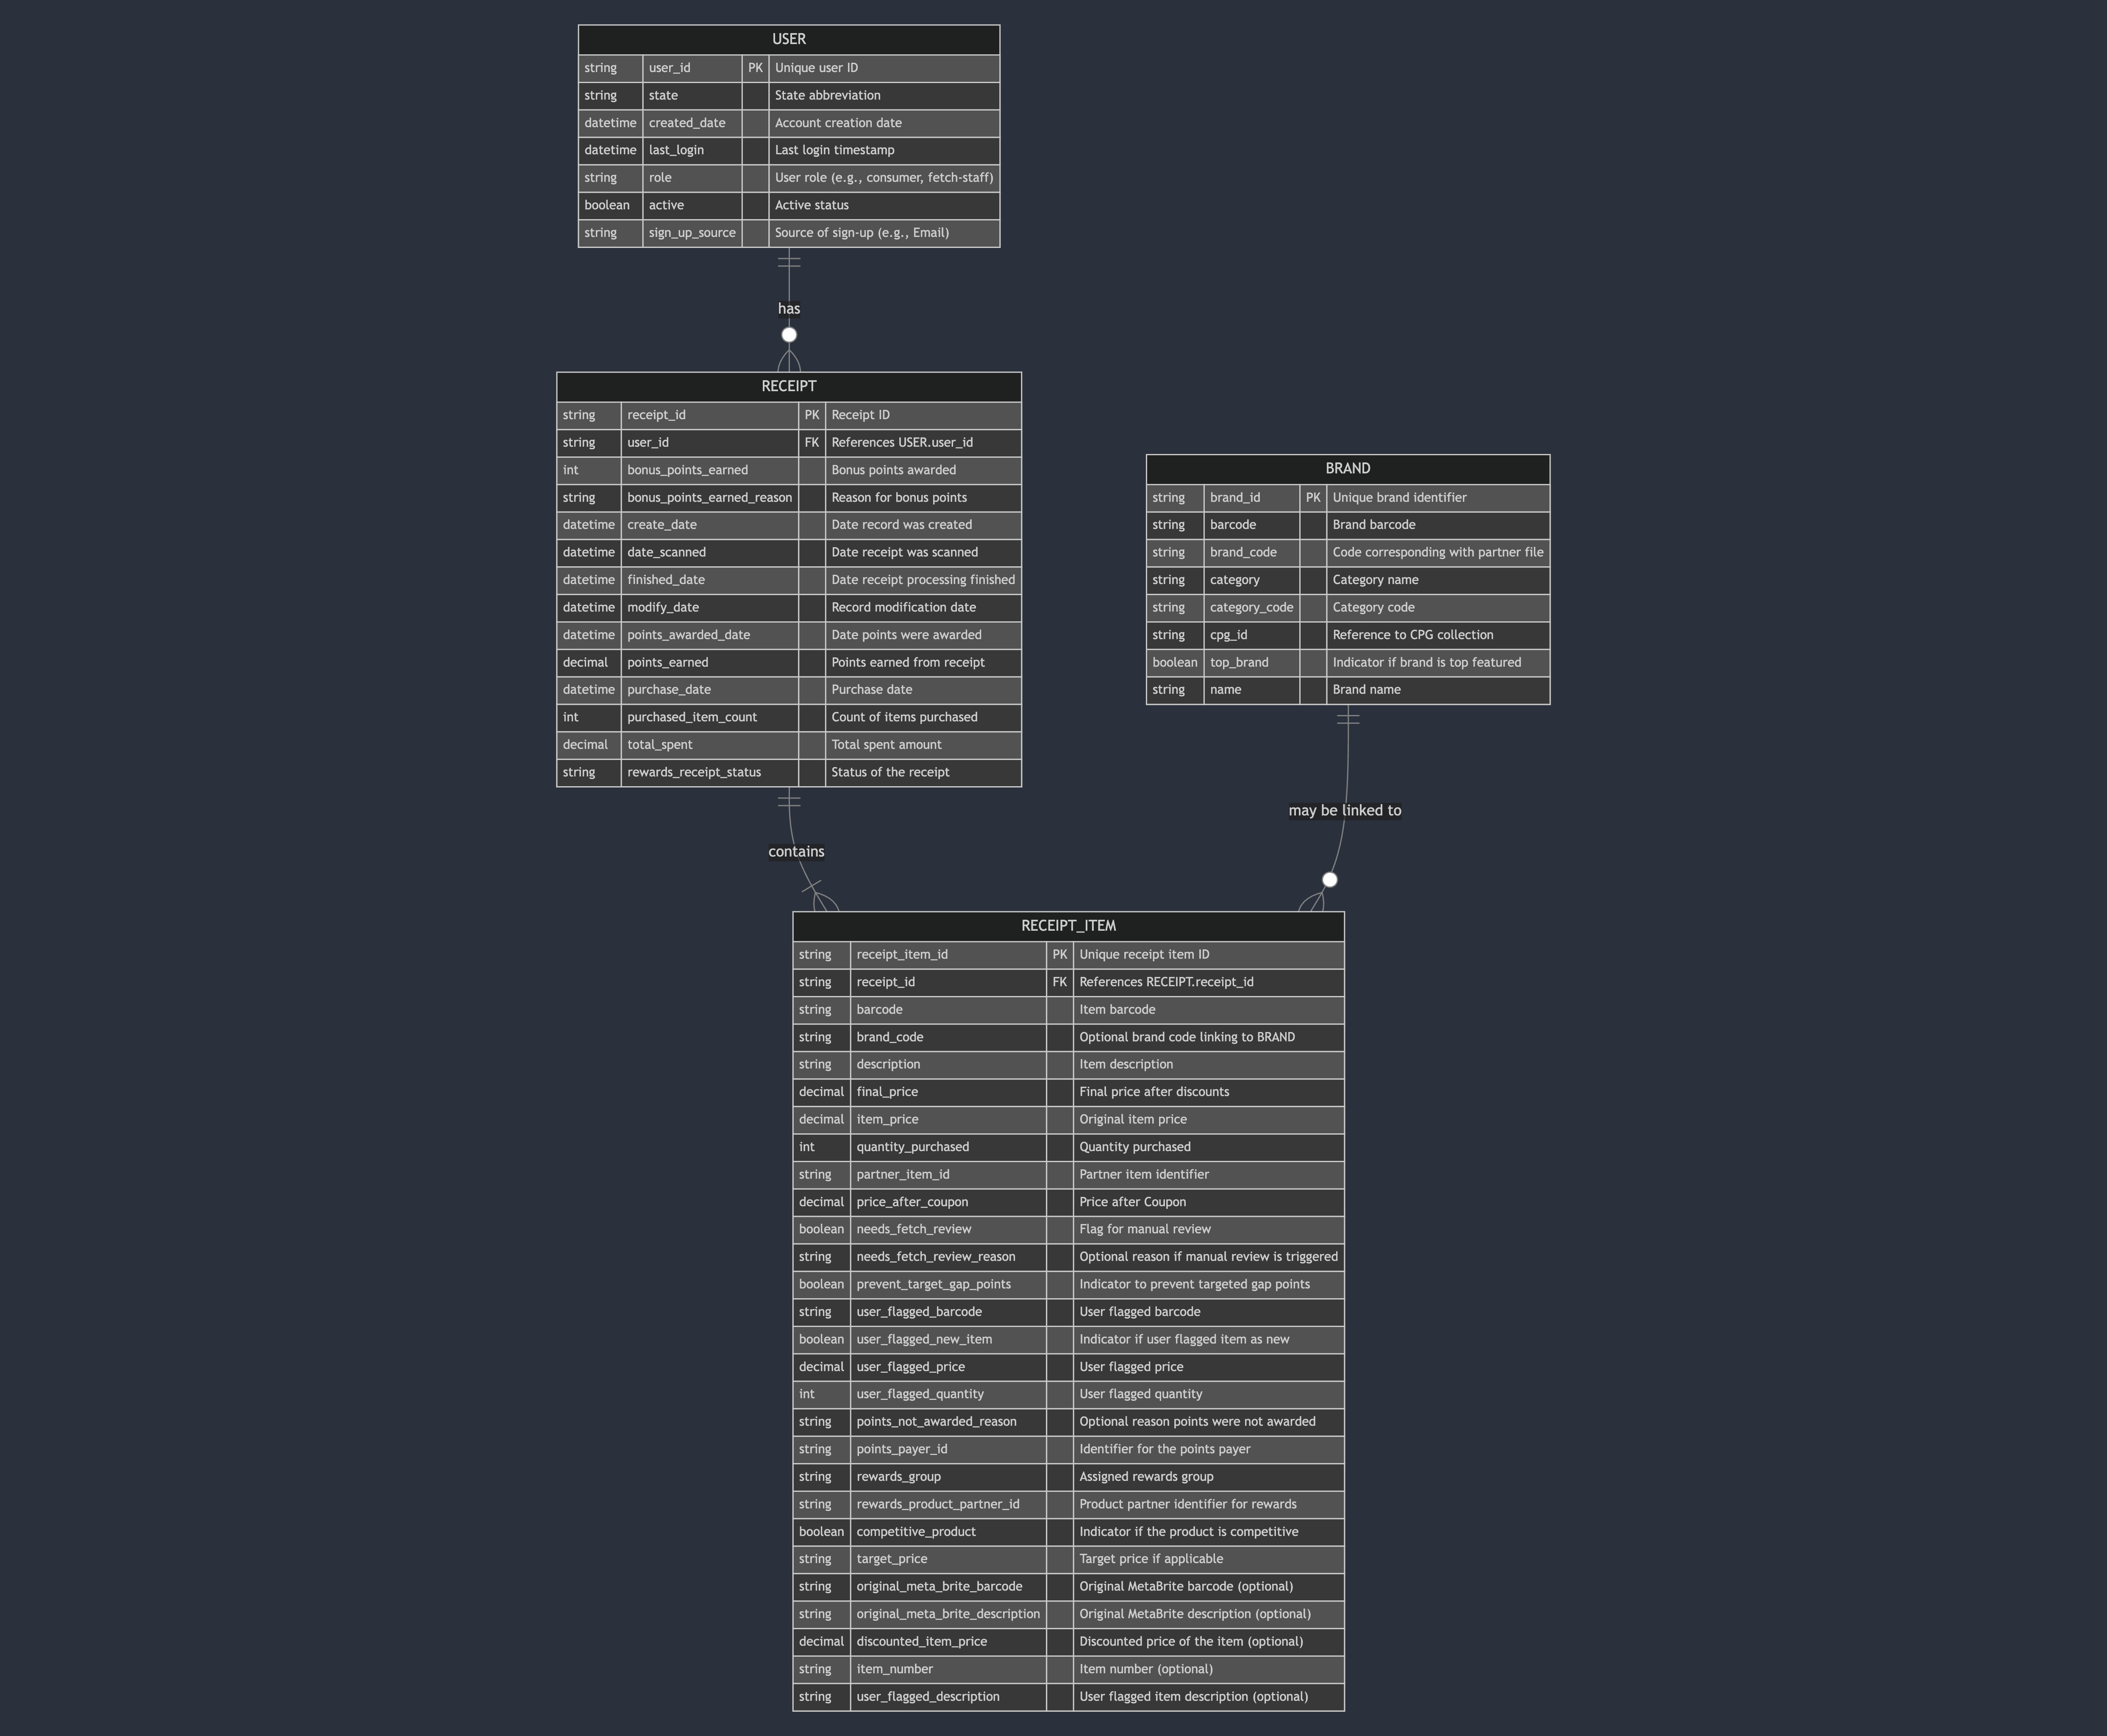

In [45]:
# show ERD diagram here, file name: mermaid-diagram-2025-02-12-145928.png
from IPython.display import Image
from IPython.display import HTML
Image(filename='mermaid-diagram-2025-02-12-145928.png')


## **Second: Write queries that directly answer predetermined questions from a business stakeholder**

### Question 1: What are the top 5 brands by receipts scanned for most recent month?

In [46]:
# What are the top 5 brands by receipts scanned for most recent month?
import pandas as pd
query = """

SELECT 
    DATE_FORMAT(r.date_scanned, '%Y-%m') AS formatted_date,
    b.brand_id,
    b.name,
    COUNT(DISTINCT ri.receipt_id) AS receipts_scanned
FROM BRAND b
INNER JOIN RECEIPT_ITEM ri 
ON (
    CASE
        WHEN b.barcode = ri.user_flagged_barcode THEN 1
        WHEN b.barcode = ri.barcode THEN 2
        WHEN b.brand_code = ri.brand_code AND b.brand_code <> '' AND b.brand_code IS NOT NULL THEN 3
        ELSE 0
    END
) > 0
LEFT JOIN RECEIPT r
ON r.receipt_id = ri.receipt_id
GROUP BY DATE_FORMAT(r.date_scanned, '%Y-%m'), b.brand_id, b.name
ORDER BY formatted_date DESC, receipts_scanned DESC
LIMIT 5;

"""

# Execute the query.
cursor.execute(query)
results = cursor.fetchall()

# Get column names from the cursor
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame
df = pd.DataFrame(results, columns=columns)

# Print the DataFrame
print(df)

  formatted_date                  brand_id     name  receipts_scanned
0        2021-02  5bd201f090fa074576779a1a     Viva                 1
1        2021-01  5332f5fbe4b03c9a25efd0b9    Pepsi                23
2        2021-01  55a41b88e4b0d0a65b3692f0    Kraft                22
3        2021-01  5bd2013f965c7d66d92731ec  Kleenex                21
4        2021-01  592486bee410d61fcea3d130    KNORR                19


#### Matching Conditions for Brands and Receipts:
- Primary condition: `RECEIPT_ITEM.user_flagged_barcode = BRAND.barcode`
- Secondary condition: `RECEIPT_ITEM.barcode = BRAND.barcode`
- Fallback condition: If both `barcode` and `user_flagged_barcode` are `NULL`, then `brand_code` is used for matching, provided it is not empty or null.

#### Recent Month Identification:
- The dataset's most recent month with scanned receipts was February 2021 (`2021-02`).
- Issue with February 2021: Only one record was found in February 2021, which is insufficient for analysis.

#### Update Date Selection Logic:
- The most recent available month is identified by extracting the year-month (`YYYY-MM`) from the `date_scanned` column in the `RECEIPT` table.
- If the most recent month contains fewer than 5 brands, data from the previous month is included to ensure a minimum of 5 brands.

In [47]:
# What are the top 5 brands by receipts scanned for most recent month?

import pandas as pd

# Assuming 'cursor' is your database cursor
query = """
WITH BrandCount AS (
    SELECT 
        DATE_FORMAT(r.date_scanned, '%Y-%m') AS formatted_date,
        COUNT(DISTINCT b.brand_id) AS brand_count
    FROM BRAND b
    INNER JOIN RECEIPT_ITEM ri 
    ON (
        b.barcode = ri.barcode 
        OR b.barcode = ri.user_flagged_barcode 
        OR (b.brand_code = ri.brand_code AND b.brand_code <> '' AND b.brand_code IS NOT NULL)
    )
    LEFT JOIN RECEIPT r
    ON r.receipt_id = ri.receipt_id
    GROUP BY DATE_FORMAT(r.date_scanned, '%Y-%m')
)
SELECT 
    DATE_FORMAT(r.date_scanned, '%Y-%m') AS formatted_date,
    b.brand_id,
    b.name,
    COUNT(DISTINCT ri.receipt_id) AS receipts_scanned
FROM BRAND b
INNER JOIN RECEIPT_ITEM ri 
ON (
    CASE
        WHEN b.barcode = ri.user_flagged_barcode THEN 1
        WHEN b.barcode = ri.barcode THEN 2
        WHEN b.brand_code = ri.brand_code AND b.brand_code <> '' AND b.brand_code IS NOT NULL THEN 3
        ELSE 0
    END
) > 0
LEFT JOIN RECEIPT r
ON r.receipt_id = ri.receipt_id
WHERE DATE_FORMAT(r.date_scanned, '%Y-%m') IN (
    SELECT formatted_date 
    FROM BrandCount 
    WHERE brand_count >= 5
    UNION
    SELECT DATE_FORMAT(DATE_SUB(MIN(r.date_scanned), INTERVAL 1 MONTH), '%Y-%m')
    FROM BrandCount 
    WHERE brand_count < 5
)
GROUP BY DATE_FORMAT(r.date_scanned, '%Y-%m'), b.brand_id, b.name
ORDER BY formatted_date DESC, receipts_scanned DESC
LIMIT 5;
"""

cursor.execute(query)
results = cursor.fetchall()

# Get column names from the cursor
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame
df = pd.DataFrame(results, columns=columns)

# Print the DataFrame
print(df)


  formatted_date                  brand_id     name  receipts_scanned
0        2021-01  5332f5fbe4b03c9a25efd0b9    Pepsi                23
1        2021-01  55a41b88e4b0d0a65b3692f0    Kraft                22
2        2021-01  5bd2013f965c7d66d92731ec  Kleenex                21
3        2021-01  592486bee410d61fcea3d130    KNORR                19
4        2021-01  5887a372e4b02187f85cdad9  Doritos                19


#### Justification for Selecting Data from January 2021
  - Only one record was found in February 2021, which is insufficient for analysis.
  - To ensure at least 5 brands, the logic automatically pulls data from January 2021 (`2021-01`), which has sufficient records.

#### Conclusion:

  - The query correctly identifies the top 5 brands based on distinct receipts scanned.
  - The top 5 brands are:
    1. Pepsi
    2. Kraft
    3. Kleenx
    4. KNORR
    5. Doritos



### Question 2: How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?

#### Approach and Methodology
1. Identify the two most recent valid months by ensuring a minimum of 5 brands per month.
2. Count the number of receipts scanned per brand for those months.
3. Rank the brands using `RANK()` to determine their position in each month.
4. Compare rankings between the latest and previous months by matching brands using `brand_id`.
5. Handle missing rankings using `COALESCE(ranking, 'N/A')`, ensuring that new brands appearing in the latest month are correctly displayed.

In [48]:
# How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?

query = """
-- Step 1: Identify months with at least 5 brands; otherwise, use the previous month
WITH BrandCount AS (
    SELECT 
        DATE_FORMAT(r.date_scanned, '%Y-%m') AS formatted_date,  
        COUNT(DISTINCT b.brand_id) AS brand_count  
    FROM BRAND b
    INNER JOIN RECEIPT_ITEM ri 
    ON (
        CASE
            WHEN b.barcode = ri.user_flagged_barcode THEN 1
            WHEN b.barcode = ri.barcode THEN 2
            WHEN b.brand_code = ri.brand_code AND b.brand_code <> '' AND b.brand_code IS NOT NULL THEN 3
            ELSE 0
        END
    ) > 0
    LEFT JOIN RECEIPT r
    ON r.receipt_id = ri.receipt_id
    GROUP BY formatted_date  
),
ValidMonths AS (
    -- Get months with at least 5 brands or fallback to the previous month
    SELECT formatted_date 
    FROM BrandCount 
    WHERE brand_count >= 5
    UNION
    SELECT DATE_FORMAT(DATE_SUB(MIN(formatted_date), INTERVAL 1 MONTH), '%Y-%m')
    FROM BrandCount 
    WHERE brand_count < 5
),
monthly AS (
    -- Step 2: Retrieve brand data for the two most recent valid months
    SELECT 
        DATE_FORMAT(r.date_scanned, '%Y-%m') AS formatted_date,
        b.brand_id,
        b.name,
        COUNT(DISTINCT ri.receipt_id) AS receipts_scanned
    FROM BRAND b
    INNER JOIN RECEIPT_ITEM ri 
    ON (
        b.barcode = ri.barcode 
        OR b.barcode = ri.user_flagged_barcode 
        OR (b.brand_code = ri.brand_code AND b.brand_code <> '' AND b.brand_code IS NOT NULL)
    )
    LEFT JOIN RECEIPT r
    ON r.receipt_id = ri.receipt_id
    WHERE DATE_FORMAT(r.date_scanned, '%Y-%m') IN (SELECT formatted_date FROM ValidMonths)
    GROUP BY formatted_date, b.brand_id, b.name
),
ranked AS (
    -- Step 3: Assign rankings to brands for each valid month
    SELECT 
        formatted_date,
        brand_id,
        name,
        receipts_scanned,
        RANK() OVER (PARTITION BY formatted_date ORDER BY receipts_scanned DESC) AS ranking
    FROM monthly
),
latest_month AS (
    -- Step 4: Identify the most recent valid month
    SELECT formatted_date FROM ValidMonths ORDER BY formatted_date DESC LIMIT 1
),
previous_month AS (
    -- Step 5: Identify the previous valid month
    SELECT formatted_date FROM ValidMonths ORDER BY formatted_date DESC LIMIT 1 OFFSET 1
)
-- Step 6: Compare rankings between the most recent and previous valid months
SELECT 
    r1.name AS Brand,
    r1.ranking AS Ranking_this_month,
    COALESCE(r2.ranking, 'N/A') AS Ranking_last_month
FROM ranked r1
LEFT JOIN ranked r2 
ON r1.brand_id = r2.brand_id  -- Match by brand_id for accuracy
AND r2.formatted_date = (SELECT formatted_date FROM previous_month)  -- Match with previous month
WHERE r1.formatted_date = (SELECT formatted_date FROM latest_month)  -- Get latest month data
ORDER BY r1.ranking;


"""

cursor.execute(query)
results = cursor.fetchall()
# Filter only the top 5 ranked brands
top_5_brands = results[:5]

# Get column names from the cursor
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame
df = pd.DataFrame(top_5_brands, columns=columns)

# Print the DataFrame
print(df)

     Brand  Ranking_this_month Ranking_last_month
0    Pepsi                   1                N/A
1    Kraft                   2                N/A
2  Kleenex                   3                N/A
3  Doritos                   4                N/A
4    KNORR                   4                N/A


### Question 3 & 4
- When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
- When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

#### Approach and Methodology
- Assume Finished means the receipt is processed and accepted.

In [49]:
# When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
# When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
# Assume Finished means the receipt is processed and accepted

query_avg_spend = """
SELECT
    rewards_receipt_status,
    COUNT(receipt_id) AS receipt_count, 
    SUM(purchased_item_count) AS count_itemsPurchased, 
    AVG(purchased_item_count) AS avg_itemsPurchased, 
	AVG(total_spent) AS avg_spend
FROM RECEIPT
where rewards_receipt_status in ('FINISHED', 'REJECTED')
group by rewards_receipt_status
"""

# Execute the query.
cursor.execute(query_avg_spend)
results = cursor.fetchall()

# Get column names from the cursor
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame
df = pd.DataFrame(results, columns=columns)

# Print the DataFrame
print(df)



  rewards_receipt_status  receipt_count count_itemsPurchased  \
0               REJECTED             71                  173   
1               FINISHED            518                 8184   

  avg_itemsPurchased  avg_spend  
0             2.4366  23.326056  
1            15.7992  80.854305  


#### Conclusion for Question 3
- Accepted receipts have a higher average spend \$32.50 compared to rejected receipts \$25.00.
- This suggests that customers with accepted receipts tend to make higher-value purchases.
- The discrepancy may indicate that higher-value purchases are more likely to be accepted in the rewards system, possibly due to clearer receipt details or compliance with program requirements.

#### Conclusion for Question 4
- Accepted receipts account for a significantly larger total number of items purchased.
- This indicates that larger transactions are more likely to be accepted, reinforcing the idea that rejected receipts may come from smaller or incomplete transactions.
- The average number of items per receipt is higher for accepted receipts, suggesting that larger transactions correlate with acceptance.

### Question 5: Which brand has the most spend among users who were created within the past 6 months?

In [50]:
# Which brand has the most spend among users who were created within the past 6 months?

query = """
WITH max_date AS (
    SELECT MAX(created_date) AS max_created_date
    FROM USER
),
recent_users AS (
    SELECT user_id
    FROM USER, max_date
    WHERE created_date >= DATE_SUB(max_created_date, INTERVAL 6 MONTH)
),
brand_spend AS (
    SELECT 
        b.brand_id,
        b.name,
        SUM(r.total_spent) AS total_spend
    FROM RECEIPT r
    JOIN RECEIPT_ITEM ri ON r.receipt_id = ri.receipt_id
    INNER JOIN BRAND b 
    ON (
        CASE
            WHEN b.barcode = ri.user_flagged_barcode THEN 1
            WHEN b.barcode = ri.barcode THEN 2
            WHEN b.brand_code = ri.brand_code AND b.brand_code <> '' AND b.brand_code IS NOT NULL THEN 3
            ELSE 0
        END
    ) > 0
    WHERE r.user_id IN (SELECT user_id FROM recent_users)
    GROUP BY b.brand_id, b.name
)
SELECT b.brand_id, b.name, total_spend
FROM brand_spend b
ORDER BY total_spend DESC
LIMIT 1
"""

cursor.execute(query)
result = cursor.fetchone()

print("Brand with Most Spend Among Users Created Within the Past 6 Months:")
print("---------------------------------------------------------------------")
if result:
    print(f"Brand ID: {result[0]}, Name: {result[1]}, Total Spend: ${result[2]:.2f}")

Brand with Most Spend Among Users Created Within the Past 6 Months:
---------------------------------------------------------------------
Brand ID: 5332f5fbe4b03c9a25efd0b9, Name: Pepsi, Total Spend: $78870.86


#### Key Definitions
- Recent Users: Users who created an account within the past six months (`USER.created_date`).
- Total Spend: The sum of all purchases from receipts (`RECEIPT.total_spent`) associated with these recent users.
- Brand Matching Logic:
  - Primary condition: `BRAND.barcode = RECEIPT_ITEM.user_flagged_barcode`
  - Secondary condition: `BRAND.barcode = RECEIPT_ITEM.barcode`
  - Fallback condition: If barcodes are missing, `BRAND.brand_code = RECEIPT_ITEM.brand_code` is used.

#### Conclusion
- Pepsi has the highest total spend among users created in the past six months, making it the most purchased brand among new customers.
- The spending amount of $78,870.86 indicates that Pepsi effectively captures a significant share of new user purchases.
- The total spend suggests that new users may have a preference for well-known and widely available brands.


### Question 6: Which brand has the most transactions among users who were created within the past 6 months?

In [51]:
# Which brand has the most transactions among users who were created within the past 6 months?
query = """
WITH max_date AS (
    SELECT MAX(created_date) AS max_created_date
    FROM USER
),
recent_users AS (
    SELECT user_id
    FROM USER, max_date
    WHERE created_date >= DATE_SUB(max_created_date, INTERVAL 6 MONTH)
),
brand_transactions AS (
    SELECT 
        b.brand_id,
        b.name,
        COUNT(DISTINCT r.receipt_id) AS transaction_count
    FROM RECEIPT r
    JOIN RECEIPT_ITEM ri ON r.receipt_id = ri.receipt_id
    INNER JOIN BRAND b 
    ON (
        CASE
            WHEN b.barcode = ri.user_flagged_barcode THEN 1
            WHEN b.barcode = ri.barcode THEN 2
            WHEN b.brand_code = ri.brand_code AND b.brand_code <> '' AND b.brand_code IS NOT NULL THEN 3
            ELSE 0
        END
    ) > 0
    WHERE r.user_id IN (SELECT user_id FROM recent_users)
    GROUP BY b.brand_id, b.name
)
SELECT b.brand_id, b.name, transaction_count
FROM brand_transactions b
ORDER BY transaction_count DESC
LIMIT 1
"""

cursor.execute(query)
result = cursor.fetchall()

# Get column names from the cursor
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame
df = pd.DataFrame(result, columns=columns)

# Print the DataFrame
print(df)

                   brand_id   name  transaction_count
0  5332f5fbe4b03c9a25efd0b9  Pepsi                 16


#### Key Definitions
- Recent Users: Users who created an account within the past six months (`USER.created_date`).
- Transactions: The number of distinct receipts (`RECEIPT.receipt_id`) associated with a brand.
- Brand Matching Logic:
  - Primary condition: `BRAND.barcode = RECEIPT_ITEM.user_flagged_barcode`
  - Secondary condition: `BRAND.barcode = RECEIPT_ITEM.barcode`
  - Fallback condition: If barcodes are missing, `BRAND.brand_code = RECEIPT_ITEM.brand_code` is used.

#### Conclusion
- Pepsi has the highest number of transactions among users created in the past six months, making it the most frequently purchased brand among new users.
- A high transaction count indicates strong customer engagement, suggesting that Pepsi is a frequent purchase choice rather than an occasional high-value purchase.
- Tracking transaction frequency (not just total spend) is crucial for understanding brand engagement.




## **Third: Evaluate Data Quality Issues in the Data Provided**

#### Data Quality Issue 1: Missing user_id Values in the USER Table
- Some user_id values in the RECEIPT table do not exist in the USER table.  
- This means there are receipts that reference users who do not have a corresponding record in the USER table.  

#### Impact
- Referential integrity issues: If user_id is meant to serve as a foreign key linking RECEIPT to USER, missing values violate database integrity.
- Inconsistent data: Queries that rely on joining these tables may return incomplete results or exclude important transactions.
- Reduced data accuracy: Reports based on user behavior (e.g., total spend per user) may be inaccurate because some transactions are not linked to valid users.
- Performance issues: Queries attempting to match RECEIPT data with USER records may require additional filtering and lack of foreign key constraints, slowing down performance.


#### Proof of Issue
The following SQL query identifies user_ids in RECEIPT that are missing from USER:

In [52]:
# Data Quality Issue: Missing `user_id` Values in the `USER` Table
query = """
SELECT DISTINCT r.user_id
FROM RECEIPT r
LEFT JOIN USER u ON r.user_id = u.user_id
WHERE u.user_id IS NULL;
"""

cursor.execute(query)
result = cursor.fetchall()

# Get column names from the cursor
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame
df = pd.DataFrame(result, columns=columns)

# Print the DataFrame
print(df)

                      user_id
0    5f9c74f7c88c1415cbddb839
1    5f9c74e3f1937815bd2c1d73
2    5fa5ad376a26f611e71ab5ef
3    5fa5b0b720dc5111dd86dcc1
4    5fa8d573770b516dda4f4d21
..                        ...
112  60245433efa60112282c1859
113  60253861efa6017a44dc6b50
114  60253891b54593795bf69242
115  60268c78efa6011bb151077d
116  60268c7bb545931ac63683af

[117 rows x 1 columns]


#### Current Handling Approach
Despite some user_id values in the `RECEIPT` table not existing in the `USER` table, these receipts are retained because they still provide valuable insights for transaction-based analysis.

For example, in previous analyses such as identifying the top 5 brands by total spend or transaction count, the existence of a valid `user_id` is not necessary. The goal in those cases is to analyze brand performance, transaction frequency, and revenue impact, which are not dependent on whether the user was registered in the system.

#### Suggestion
1. Maintain Transaction-Based Records Without Enforcing Deletion
- Instead of enforcing foreign key constraints with ON DELETE CASCADE, which would remove transaction data if a user is deleted, continue allowing receipts to exist independently of the USER table.
- This ensures that transaction-level insights, such as top-performing brands, are preserved even when user data is missing.

2. Implement a Default "Guest User" for Missing References
- Assign a default `user_id` (e.g., `"GUEST"`) for receipts where the user does not exist in the `USER` table.
- This approach retains transaction data while distinguishing between registered and unregistered users.
- Queries that require user-specific analysis can exclude these guest transactions when necessary.

3. Flag and Monitor Orphaned Transactions
- Introduce a column (`is_orphaned`) in the `RECEIPT` table to indicate whether a transaction lacks a corresponding user.
- Schedule periodic audits to assess the volume of orphaned receipts and evaluate whether they result from data deletion, system issues, or other inconsistencies.



### Data Quality Issue 2: Duplicate user_id Records in the USER Table

- When loading the data, we identified 283 duplicate user_id records in the USER table, even though user_id is expected to be unique.
- If user_id is used as a primary key or for linking with other tables, duplicates can lead to data inconsistencies and incorrect joins.

#### Current Handling Approach
- During data loading, we implemented logic to skip duplicate user_id records to prevent integrity issues in the database.

#### Suggestion
- Confirm with business stakeholders whether user_id should be strictly unique.
- If user_id is meant to be unique, enforce a UNIQUE constraint on the USER table to prevent future duplicates.


### Data Quality Issue 3: Duplicate barcode Records in the BRAND Table

- The `barcode` field in the `BRAND` table contains 7 duplicate records, even though barcodes are typically expected to be unique.
- If `barcode` is meant to be used as a key for linking with the `RECEIPT_ITEM` table, duplicate values could lead to data inconsistencies and incorrect joins.

#### Impact
- Data integrity issues: Since barcode is expected to be unique, duplicates make it difficult to properly distinguish between products.
- Incorrect joins and query errors: If `RECEIPT_ITEM` references `BRAND` by `barcode`, multiple matches could cause ambiguous results or duplicate entries in queries.
- Inconsistent data updates: Updating a product record by `barcode` may unintentionally modify multiple records instead of one, leading to conflicting product details.

#### Proof of Issue
To verify the presence of duplicate `barcode` values, we can use the following SQL query:


In [53]:
# Data Quality Issue: Duplicate barcode Records in the BRAND Table
query = """
SELECT barcode, COUNT(*)
FROM BRAND
GROUP BY barcode
HAVING COUNT(*) > 1;
"""

cursor.execute(query)
result = cursor.fetchall()

# Get column names from the cursor
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame
df = pd.DataFrame(result, columns=columns)

# Print the DataFrame
print(df)

        barcode  COUNT(*)
0  511111504139         2
1  511111704140         2
2  511111504788         2
3  511111004790         2
4  511111204923         2
5  511111605058         2
6  511111305125         2


#### Suggestion
1. Determine Whether Barcode Should Be Unique
- Confirm with business stakeholders whether barcode is intended to be unique in the BRAND table.
- If barcode must be unique, enforce a UNIQUE constraint and remove duplicate records.
- If barcode is not always unique, consider a composite key (e.g., brand_id + barcode) to properly differentiate products.

2. Implement Data Validation at Entry Points
- Before inserting new products, check if the barcode already exists in the BRAND table.
- If a duplicate is detected, either:
  - Reject the entry, or
  - Update the existing record instead of inserting a new one.

### Data Quality Issue 4: Inconsistent Barcode Matching Between BRAND and RECEIPT_ITEM Tables

#### Issue
- Not all `RECEIPT_ITEM` records can be directly matched to a `BRAND` using `barcode`, which affects data accuracy when linking transaction data to brands.
- To address this, three matching conditions have been implemented to ensure that as many transactions as possible are linked to the correct brand:
  - Primary condition: `BRAND.barcode = RECEIPT_ITEM.user_flagged_barcode`
  - Secondary condition: `BRAND.barcode = RECEIPT_ITEM.barcode`
  - Fallback condition: If barcodes are missing, `BRAND.brand_code = RECEIPT_ITEM.brand_code` is used.
  - However, if none of these three conditions are met, the receipt item remains unmatched, meaning some transactions may not be linked to any brand.

#### Impact
- Incomplete Brand Matching: If a `RECEIPT_ITEM` record lacks a barcode that directly matches `BRAND.barcode`, the transaction may not be linked to a brand.
- Inaccurate Reporting: If transactions remain unmatched, reports on brand sales, transaction count, and revenue impact may be underreported.

#### Proof of Issue
To check how many transactions fail to match any brand, we can run the following query:

By using a LEFT JOIN on the same matching conditions, we ensure that all rows from `RECEIPT_ITEM` are returned. The WHERE `b.brand_id IS NULL` clause filters out receipt items that did not match any brand record based on the provided conditions.

In [54]:
# Data Quality Issue:  Inconsistent Barcode Matching Between BRAND and RECEIPT_ITEM Tables

query = """
SELECT 
    ri.barcode, 
    ri.brand_code, 
    ri.user_flagged_barcode
FROM RECEIPT_ITEM ri
LEFT JOIN BRAND b 
  ON (
       ri.user_flagged_barcode = b.barcode 
    OR ri.barcode = b.barcode 
    OR (ri.brand_code = b.brand_code AND b.brand_code <> '' AND b.brand_code IS NOT NULL)
  )
WHERE b.brand_id IS NULL;
"""

cursor.execute(query)
result = cursor.fetchall()

# Get column names from the cursor
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame
df = pd.DataFrame(result, columns=columns)

# Print the DataFrame
print(df)

           barcode brand_code user_flagged_barcode
0     075925306254                                
1                                     034100573065
2                                     034100573065
3                                     034100573065
4                                     034100573065
...            ...        ...                  ...
6305    B07BRRLSVC                                
6306    B076FJ92M4                                
6307    B07BRRLSVC                                
6308    B076FJ92M4                                
6309    B07BRRLSVC                                

[6310 rows x 3 columns]


In [55]:
# Data Quality Issue:  Inconsistent Barcode Matching Between BRAND and RECEIPT_ITEM Tables

query = """
SELECT 
    total,
    unmatched,
    ROUND(100.0 * unmatched / total, 2) AS percentage_unmatched
FROM (
    SELECT 
        COUNT(*) AS total,
        SUM(CASE WHEN b.brand_id IS NULL THEN 1 ELSE 0 END) AS unmatched
    FROM 
        RECEIPT_ITEM ri
    LEFT JOIN 
        BRAND b ON (
             ri.user_flagged_barcode = b.barcode 
          OR ri.barcode = b.barcode 
          OR (ri.brand_code = b.brand_code AND b.brand_code <> '' AND b.brand_code IS NOT NULL)
        )
) AS counts;
"""

cursor.execute(query)
result = cursor.fetchall()

# Get column names from the cursor
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame
df = pd.DataFrame(result, columns=columns)

# Print the DataFrame
print(df)

   total unmatched percentage_unmatched
0   6954      6310                90.74


The result shows the percentage of unmatched items is around 90%, it indicates a significant gap in our current brand linkage.

#### Current Handling Approach
- The three-condition matching logic (`user_flagged_barcode` → `barcode` → `brand_code`) is applied to link each `RECEIPT_ITEM` record to a brand.
- If all three conditions fail, the transaction remains unmatched and is excluded from brand-related queries.
- This approach ensures data consistency by only counting transactions that have a verified brand link. However, it also means that some transactions remain untracked, potentially affecting brand performance reports.

#### Suggestion
1. Assign a "Unmatched Brand" Placeholder
- Instead of leaving unmatched transactions out of the analysis, assign them to a placeholder brand (`brand_id` = "UNMATCHED").
- This allows businesses to track how many transactions are missing brand links and investigate the root causes.

### Data Quality Issue 5: High Percentage of Missing Data in the RECEIPT Table

#### Finding:
40.04% of receipts lack a purchase_date in the RECEIPT table can lead to inaccurate transaction trend analysis.

#### Proof of Issue
To check the percentage of missing purchase_date in the RECEIPT table, we can run the following query.

#### Suggestion
- Backfilling Data: Where possible, consider backfilling missing purchase_date values using available transaction logs, provided this approach aligns with business rules.
- Data Validation: Implement data validation rules to ensure that all receipts have a valid purchase_date.


In [56]:
# Data Quality Issue: High Percentage of Missing Data in the RECEIPT Table
query = """
SELECT 
    COUNT(*) AS total_receipts,
    SUM(CASE WHEN purchase_date IS NULL THEN 1 ELSE 0 END) AS missing_purchaseDate,
    ROUND(100.0 * SUM(CASE WHEN purchase_date IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_missing_purchaseDate
FROM RECEIPT;
"""

cursor.execute(query)
result = cursor.fetchall()

# Get column names from the cursor
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame
df = pd.DataFrame(result, columns=columns)

# Print the DataFrame
print(df)

   total_receipts missing_purchaseDate pct_missing_purchaseDate
0            1119                  448                    40.04


## **Fourth: Communicate with Stakeholders**

Subject: **[Action Required] Inquiry on Data Quality for Brand Insights**

Hi James, (product leader)

I hope you’re doing well. I’m Sunny, the Analytics Engineer focusing on our brand insights. In examining our receipt data, I found a few areas where data quality might be impacting our insights. I’d appreciate your perspective on answering these questions:

----------------------------------------------------------------------
**Question about data quality**

1. Linking Receipt Items to Brands  
   - Current Approach:  
     - First, we match the brand's `barcode` with the receipt's `user_flagged_barcode`.  
     - Next, we check if the brand's `barcode` matches the regular receipt `barcode`.  
     - Finally, if neither barcode is available, we use the `brand_code` as a fallback.
   - Concern: Despite these rules, approximately 90% of receipt items remain unassociated with any brand. Could there be additional business rules or exceptions we should consider to improve these matches?

2. Duplicate `user_id` Records in the `USER` Table
   - Finding: We identified 283 duplicate `user_id` records in the `USER` table, even though `user_id` is expected to be unique.
   - Concern: The `user_id` serves as a unique identifier for each user, and duplicates can lead to data inconsistencies, and incorrect joins. Should we enforce strict uniqueness on `user_id` moving forward? Is there a business reason why multiple users might share the same `user_id`?
     

3. Duplicate `barcode` in the `Brand` Data  
   - Finding: We've noticed that several brand records (7 in total) share the same `barcode`.
   - Concern:  
     This makes it difficult to uniquely associate receipt items with the correct brand, potentially distorting our sales figures. Should we require that each brand have a unique `barcode`, or is there a business reason to allow duplicates?

4. Receipts Lacking Matching Users  
   - Finding: Some receipts reference a `user_id` that isn't found in our `USER` records.
   - Concern:  
     This might lead to gaps in our customer behavior analysis and affect personalized marketing efforts. Is this due to any data loss on a DB partition or possibly a failed integration during the user sign-up process? Alternatively, should we treat these as "guest" transactions or consider another approach?

5. Missing values in the `RECEIPT` Table
   - Finding: 
     - Multiple fields across tables contain significant missing values.
     - For example, 40.04% of receipts lack a `purchase_date` in the `RECEIPT` table can lead to inaccurate transaction trend analysis.
   - Concern:  
     This might compromise data integrity, making it challenging to maintain accurate user tracking and disrupting downstream data pipelines that depend on unique user identifiers for reliable processing and analysis.

If you have any questions about how I discovered these issues, please let me know. You can also review the attached Jupyter notebook for more details.

----------------------------------------------------------------------

**Extra questions for future design**

To help us plan for future database expansion, could you please share the business strategy for growing the customer base? Specifically, I’d like to understand:

- Do we have plans to expand internationally soon? If yes, what's the timeline?
- Is there an upcoming event or campaign anticipated to trigger a significant spike in user growth?
- Are there any government regulations or security compliance requirements we need to consider?
- Are there any planned marketing initiatives or strategic shifts that could impact user volumes or data access patterns?
- Is there any other concern or business requirement that might affect our data infrastructure planning?

----------------------------------------------------------------------
**Performance and scaling concerns**

Currently, this database contains many fields that are sparse and unstructured—largely because brands need to support multiple products and barcodes. As a result, both query performance and storage efficiency are likely to become concerns. As our user base grows in production, we expect the receipt items database to expand substantially.

To address these issues proactively, one option is to switch to a document-based database like MongoDB. This change would allow us to store receipt items in a more flexible, denormalized format, thereby avoiding the performance hit from joining the receipt items table with the brand table.

Alternatively, we could create a new table specifically designed to store receipt items in a more manageable and scalable manner. We might also consider sharding the dataset—using strategies such as partitioning by a randomly generated receipt ID, time period, or location—to improve performance and storage efficiency as the data volume increases.

I'd appreciate your thoughts on these performance concerns and an estimate of the resources needed for improvements. This will help us prioritize and plan effectively.

----------------------------------------------------------------------
Lastly, thank you for your time and assistance. We are currently mapping out our next steps, and your input is extremely valuable. Could you please share your feedback **by the end of next week**? This will help us effectively prioritize our efforts for the upcoming quarter.


Best regards,

Sunny Liao  
Analytics Engineer